In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/video_game_sales_prediction_weekend_hackathon_10/Data.zip

--2020-06-28 13:37:59--  https://machinehack-be.s3.amazonaws.com/video_game_sales_prediction_weekend_hackathon_10/Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.120
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142509 (139K) [application/octet-stream]
Saving to: ‘Data.zip’

Data.zip            100%[===================>] 139.17K   188KB/s    in 0.7s    

2020-06-28 13:38:01 (188 KB/s) - ‘Data.zip’ saved [142509/142509]



In [ ]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
  inflating: Data/Test.csv           
  inflating: __MACOSX/Data/._Test.csv  
  inflating: Data/Train.csv          
  inflating: __MACOSX/Data/._Train.csv  
  inflating: Data/Sample_Submission.csv  
  inflating: __MACOSX/Data/._Sample_Submission.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')
sub = pd.read_csv('Data/Sample_Submission.csv')

In [ ]:
train.head(5)

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [ ]:
test.tail(5)

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
1498,3939,ps2,2004,sports,Electronic Arts,T,1.809524,0.192308
1499,961,ds,2007,platform,Take-Two Interactive,E,8.800000,0.625000
1500,3417,xone,2016,action,Insomniac Games,E,5.500000,0.333333
1501,2489,ps,2002,racing,Electronic Arts,E,8.625000,0.690000
1502,3174,pc,2010,shooter,Thq,M,1.863636,0.007629


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(ID                 0
 CONSOLE            0
 YEAR               0
 CATEGORY           0
 PUBLISHER          0
 RATING             0
 CRITICS_POINTS     0
 USER_POINTS        0
 SalesInMillions    0
 dtype: int64, ID                0
 CONSOLE           0
 YEAR              0
 CATEGORY          0
 PUBLISHER         0
 RATING            0
 CRITICS_POINTS    0
 USER_POINTS       0
 dtype: int64, (3506, 9), (1503, 8), ID                   int64
 CONSOLE             object
 YEAR                 int64
 CATEGORY            object
 PUBLISHER           object
 RATING              object
 CRITICS_POINTS     float64
 USER_POINTS        float64
 SalesInMillions    float64
 dtype: object)

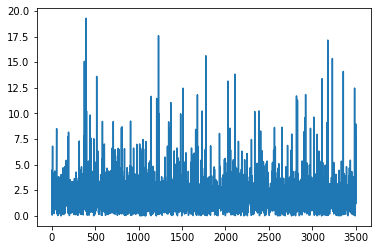

In [ ]:
train['SalesInMillions'].plot()

In [ ]:
c=0
d=0
for i in train['SalesInMillions']:
  d=d+1
  if i<20:
    pass
  else:
    print(d,i)
    c=c+1

In [ ]:
a=[966,1035,1078,1441,1679,2477,2601,2904]
for i in a:
  train=train.drop(train.index[[i]])

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df = pd.get_dummies(df, columns=['CONSOLE','YEAR','CATEGORY','PUBLISHER','RATING'])

In [ ]:
df.tail(2)

,ID,CRITICS_POINTS,USER_POINTS,SalesInMillions,CONSOLE_3ds,CONSOLE_dc,CONSOLE_ds,CONSOLE_gba,CONSOLE_gc,CONSOLE_pc,CONSOLE_ps,CONSOLE_ps2,CONSOLE_ps3,CONSOLE_ps4,CONSOLE_psp,CONSOLE_psv,CONSOLE_wii,CONSOLE_wiiu,CONSOLE_x,CONSOLE_x360,CONSOLE_xone,YEAR_1988,YEAR_1994,YEAR_1997,YEAR_1998,YEAR_1999,YEAR_2000,YEAR_2001,YEAR_2002,YEAR_2003,YEAR_2004,YEAR_2005,YEAR_2006,YEAR_2007,YEAR_2008,YEAR_2009,YEAR_2010,YEAR_2011,YEAR_2012,YEAR_2013,...,PUBLISHER_Tdk Mediactive,PUBLISHER_Team17 Software,PUBLISHER_Tecmo Koei,PUBLISHER_Telltale Games,PUBLISHER_Thq,PUBLISHER_Thq Nordic,PUBLISHER_Tomy Corporation,PUBLISHER_Topware Interactive,PUBLISHER_Touchstone,PUBLISHER_Trion Worlds,PUBLISHER_Tripwire Interactive,PUBLISHER_Tru Blu Entertainment,PUBLISHER_Ubisoft,PUBLISHER_Ubisoft Annecy,PUBLISHER_Universal Interactive,PUBLISHER_Unknown,PUBLISHER_Valcon Games,PUBLISHER_Valve,PUBLISHER_Valve Software,PUBLISHER_Virgin Interactive,PUBLISHER_Visco,PUBLISHER_Vivendi Games,PUBLISHER_Wanadoo,PUBLISHER_Warner Bros. Interactive Entertainment,PUBLISHER_White Park Bay Software,PUBLISHER_Xicat Interactive,PUBLISHER_Xplosiv,PUBLISHER_Xs Games,PUBLISHER_Xseed Games,PUBLISHER_Yacht Club Games,PUBLISHER_Zoo Digital Publishing,PUBLISHER_Zoo Games,PUBLISHER_Zushi Games,RATING_AO,RATING_E,RATING_E10+,RATING_K-A,RATING_M,RATING_RP,RATING_T
4999,2489,8.625000,0.690000,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5000,3174,1.863636,0.007629,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train = df[df['SalesInMillions'].isnull()==False]
test = df[df['SalesInMillions'].isnull()==True]

In [ ]:
s=['CONSOLE','CATEGORY','PUBLISHER','RATING']
for i in s:
  loc = np.append(train[i].values, test[i].values, axis=0)
  from sklearn.preprocessing import LabelEncoder
  l=LabelEncoder()
  l.fit(list(set(loc)))
  train[i]=l.transform(train[i])
  test[i]=l.transform(test[i])

SyntaxError: ignored

In [ ]:
del test['SalesInMillions']

In [ ]:
train_df=train
Xtest = test

In [ ]:
X = train_df.drop(labels=['SalesInMillions'], axis=1)
y = train_df['SalesInMillions'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((2623, 297), (2623,), (875, 297), (875,))

In [ ]:
from math import sqrt 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 200,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSE:', sqrt(mean_squared_error(y_cv,y_pred_lgbm)))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.54918
[200]	valid_0's rmse: 1.49146
[300]	valid_0's rmse: 1.47422
[400]	valid_0's rmse: 1.47162
[500]	valid_0's rmse: 1.4736
Early stopping, best iteration is:
[359]	valid_0's rmse: 1.47017
RMSE: 1.4701726524700216


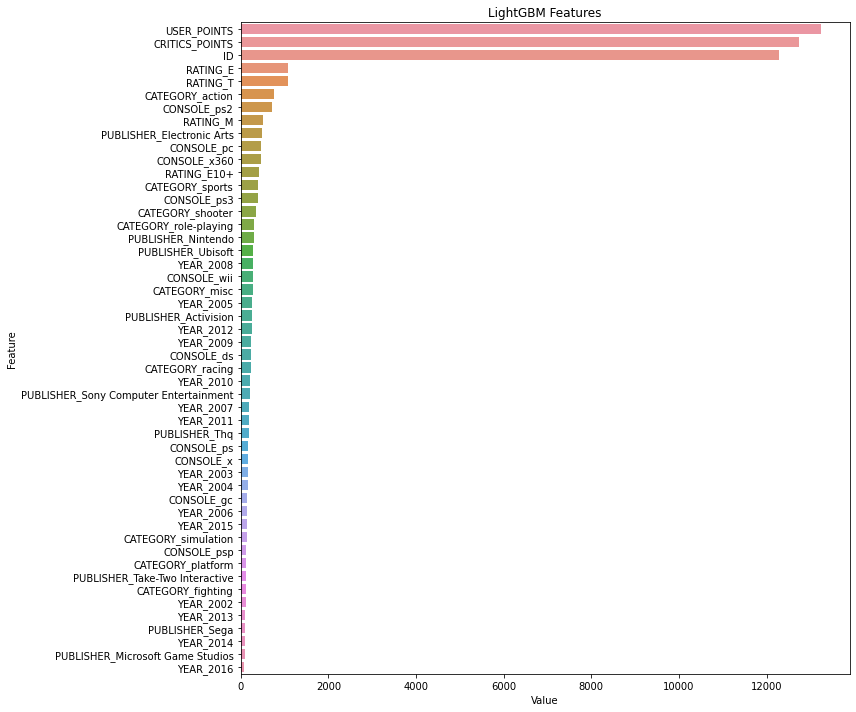

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=2**16)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #lgbm = LGBMRegressor(**param)
    lgbm = LGBMRegressor(boosting_type='gbdt', num_leaves=300, max_depth=31, learning_rate=0.01, n_estimators=5000, min_child_samples=20, subsample=0.90,bagging_fraction=0.9)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_error(y_test,y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  1.4725269974519963
RMSLE LGBM:  1.5392642478832057
RMSLE LGBM:  1.6943108539045295
RMSLE LGBM:  1.2989077656175263
RMSLE LGBM:  1.3324865785316984
RMSLE LGBM:  1.5842601593683905
RMSLE LGBM:  1.2058034550180694
RMSLE LGBM:  1.491162171935709
RMSLE LGBM:  1.361154829180662
RMSLE LGBM:  1.4125756115121693


In [ ]:
np.mean(errlgb,0)

1.4392452670403957

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([1.4785972 , 1.9121914 , 3.59658575, ..., 1.60745902, 1.91328284,
       1.55065522])

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": lgbm_final
    })
submission.to_csv('./fibo.csv', index=False)
print(submission)

      SalesInMillions
0            1.478597
1            1.912191
2            3.596586
3            2.585918
4            1.605188
...               ...
1498         2.375322
1499         1.262910
1500         1.607459
1501         1.913283
1502         1.550655

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('fibo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#gbm

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.01, n_estimators=1500, random_state=42, subsample=0.8)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('RMSE', sqrt(mean_squared_error(y_cv, y_pred)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           2.9275           0.0152           17.21s
         2           2.9458           0.0163           17.19s
         3           3.0154           0.0143           17.04s
         4           2.8766           0.0194           17.20s
         5           2.9779           0.0092           17.16s
         6           2.8765           0.0140           17.10s
         7           2.9416           0.0124           17.05s
         8           2.8184           0.0128           17.08s
         9           2.8545           0.0115           17.06s
        10           3.0156           0.0056           17.06s
        20           2.7837           0.0132           16.72s
        30           2.6396           0.0087           16.48s
        40           2.5831           0.0020           16.33s
        50           2.5869           0.0042           16.17s
        60           2.4547           0.0042           16.06s
       

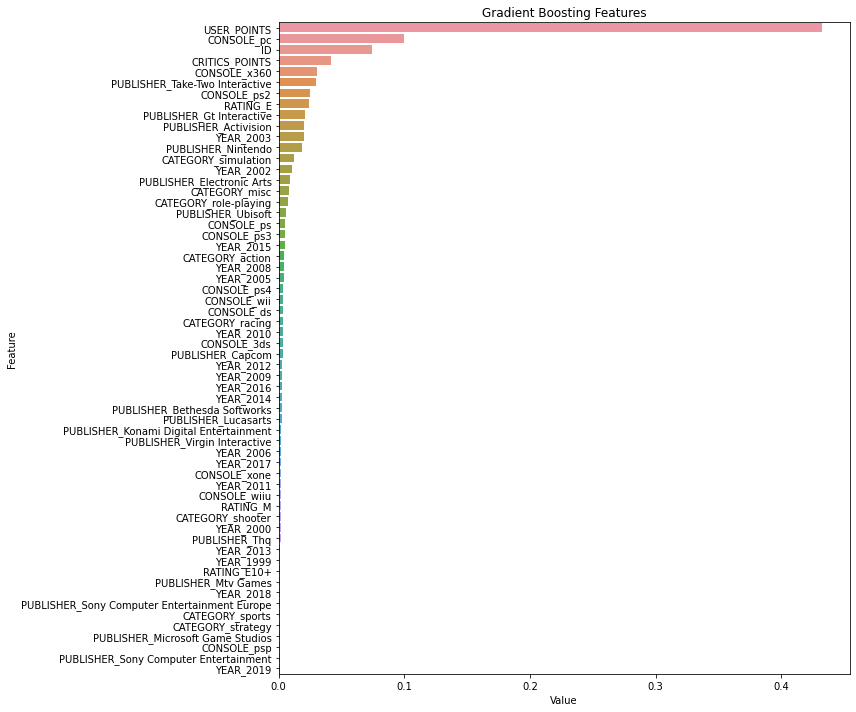

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = GradientBoostingRegressor(learning_rate=0.01, n_estimators=100, random_state=101, subsample=0.8)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

RMSE 1.7885479376481555
RMSE 1.3399578310711977
RMSE 1.5565249143613944
RMSE 1.5512651878947845
RMSE 1.4593031709830864
RMSE 1.6746622293771787
RMSE 1.5022912975059826
RMSE 1.4501531909462355
RMSE 1.434848676473714
RMSE 1.4436400167369772


In [ ]:
np.mean(errgb)

1.5201194452998705

In [ ]:
final = np.mean(y_pred_totgb,0)
final

array([1.91516922, 2.03414431, 2.3217131 , ..., 1.88070381, 1.96188674,
       2.07952741])

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": final
    })
submission.to_csv('./gbmm.csv', index=False)
print(submission)

      SalesInMillions
0            1.915169
1            2.034144
2            2.321713
3            1.964013
4            1.903854
...               ...
1498         2.040030
1499         1.882838
1500         1.880704
1501         1.961887
1502         2.079527

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('gbmm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = CatBoostRegressor(n_estimators=200, learning_rate=0.01, max_depth=9, rsm=0.5, verbose=500)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

0:	learn: 1.6683260	total: 8.69ms	remaining: 1.73s
199:	learn: 1.3614515	total: 1.58s	remaining: 0us
RMSE 1.7094533556126421
0:	learn: 1.7291265	total: 8.83ms	remaining: 1.76s
199:	learn: 1.3936995	total: 1.54s	remaining: 0us
RMSE 1.321476997912388
0:	learn: 1.7179390	total: 7.61ms	remaining: 1.51s
199:	learn: 1.3744962	total: 1.5s	remaining: 0us
RMSE 1.506783686950558
0:	learn: 1.6928354	total: 3.49ms	remaining: 695ms
199:	learn: 1.3825780	total: 1.49s	remaining: 0us
RMSE 1.499842502713842
0:	learn: 1.7160794	total: 8.06ms	remaining: 1.6s
199:	learn: 1.3911861	total: 1.54s	remaining: 0us
RMSE 1.4056239867129714
0:	learn: 1.6857235	total: 8.7ms	remaining: 1.73s
199:	learn: 1.3572795	total: 1.49s	remaining: 0us
RMSE 1.6265677810927734
0:	learn: 1.7132256	total: 8.72ms	remaining: 1.74s
199:	learn: 1.3870138	total: 1.53s	remaining: 0us
RMSE 1.4129895675532476
0:	learn: 1.7289803	total: 7.52ms	remaining: 1.5s
199:	learn: 1.3849865	total: 1.53s	remaining: 0us
RMSE 1.4176615907560643
0:	lear

In [ ]:
np.mean(errgb)

1.4715534353836304

In [ ]:
final = np.mean(y_pred_totgb,0)
final

array([1.82666319, 1.94696054, 2.33693674, ..., 1.87022504, 1.94222032,
       1.98072951])

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": final
    })
submission.to_csv('./cat_time.csv', index=False)
print(submission)

      SalesInMillions
0            1.826663
1            1.946961
2            2.336937
3            1.976426
4            1.908658
...               ...
1498         2.007605
1499         1.838801
1500         1.870225
1501         1.942220
1502         1.980730

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('cat_time.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = XGBRegressor(n_estimators=20, learning_rate=0.1, max_depth=9, verbose=100,reg='squarederror')
    gb.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='rmse', early_stopping_rounds=200,verbose=400)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

[14:17:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.56999
Will train until validation_0-rmse hasn't improved in 200 rounds.
[19]	validation_0-rmse:1.80636
RMSE 1.8063595741892748
[14:17:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.69348
Will train until validation_0-rmse hasn't improved in 200 rounds.
[19]	validation_0-rmse:2.02931
RMSE 2.0293091070396456
[14:17:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.35126
Will train until validation_0-rmse hasn't improved in 200 rounds.
[19]	validation_0-rmse:1.67589
RMSE 1.675893865416518
[14:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.44845
Will train

In [ ]:

bins=np.linspace(0, 1, 50) 
y_bin = np.digitize(y,bins)
y_bin

array([50, 11, 27, ..., 50, 50, 50])

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold

errgb = []
y_pred_totgb = []

fold=StratifiedKFold(n_splits=15,shuffle=True,random_state=1994)

for train_index, test_index in fold.split(X,y_bin):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gb=LGBMRegressor(n_estimators=10000,random_state=1994,learning_rate=0.01,num_leaves=50,boosting_type='gbdt',feature_fraction=0.6,
                objective='regression',min_child_samples=12)
    gb.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='rmse', early_stopping_rounds=200,verbose=400)
    y_pred = gb.predict(X_test)

    print('RMSE', sqrt(mean_squared_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[159]	valid_0's l2: 1.75674	valid_0's rmse: 1.32542
RMSE 1.3254193900158975
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's l2: 2.08013	valid_0's rmse: 1.44227
[800]	valid_0's l2: 2.02028	valid_0's rmse: 1.42137
Early stopping, best iteration is:
[679]	valid_0's l2: 2.01033	valid_0's rmse: 1.41786
RMSE 1.4178605298294515
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's l2: 1.80766	valid_0's rmse: 1.34449
Early stopping, best iteration is:
[509]	valid_0's l2: 1.77722	valid_0's rmse: 1.33312
RMSE 1.3331248815638281
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's l2: 1.89214	valid_0's rmse: 1.37555
Early stopping, best iteration is:
[590]	valid_0's l2: 1.86221	valid_0's rmse: 1.36463
RMSE 1.3646297809348464
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's l2: 1.56518	valid

In [ ]:
np.mean(errgb)

1.380580197133912

In [ ]:
final = np.mean(y_pred_totgb,0)
final

array([1.68763922, 2.18527548, 3.3222205 , ..., 1.64110008, 1.85474095,
       1.58691066])

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": final
    })
submission.to_csv('./lg_bin.csv', index=False)
print(submission)

      SalesInMillions
0            1.687639
1            2.185275
2            3.322221
3            2.156173
4            1.649133
...               ...
1498         2.283770
1499         1.352600
1500         1.641100
1501         1.854741
1502         1.586911

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('lg_bin.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

errxgb = []
y_pred_totxgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    xgb = XGBRegressor(random_state=42)
    xgb.fit(X_train, y_train)

    y_pred_xgb = xgb.predict(X_test)
    print("RMSLE: ", sqrt(mean_squared_error(y_test, y_pred_xgb)))

    errxgb.append(sqrt(mean_squared_error(y_test,y_pred_xgb)))
    p = xgb.predict(Xtest)
    y_pred_totxgb.append(p)

[15:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.5315661724306588
[15:36:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.4597489875514376
[15:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.2048469689309842
[15:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.5762121206175914
[15:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.1892451118558005
[15:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:  1.1828229693740198
[15:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:line

In [ ]:
np.mean(errxgb)

1.4211762698131352

In [ ]:
final = np.mean(y_pred_totxgb,0)
final

array([1.7679182, 1.9216555, 2.7987022, ..., 1.5643302, 2.0260231,
       1.7948735], dtype=float32)

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": final
    })
submission.to_csv('./xg_ghar.csv', index=False)
print(submission)

      SalesInMillions
0            1.767918
1            1.921656
2            2.798702
3            1.994435
4            1.758916
...               ...
1498         2.281577
1499         1.700323
1500         1.564330
1501         2.026023
1502         1.794873

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('xg_ghar.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ensem

In [ ]:
from google.colab import files
files.upload()

Saving xg_ghar.csv to xg_ghar.csv


{'xg_ghar.csv': b'SalesInMillions\n1.7679182\n1.9216555\n2.7987022\n1.9944347\n1.7589158\n1.9659593\n1.7008376\n1.6247847\n2.0317447\n1.5957836\n2.1761518\n1.5488805\n1.5481265\n1.4929225\n1.8077309\n2.619302\n1.6562171\n1.7147049\n1.5494128\n4.354058\n1.6432071\n1.7348027\n1.8449447\n3.7850797\n1.839905\n1.7250944\n1.6295981\n1.6025473\n1.6538091\n2.4902868\n1.5482482\n1.7469037\n6.2501364\n4.008121\n1.7921004\n1.7582957\n1.7524621\n1.9331717\n1.7608638\n1.571657\n2.0512574\n1.87518\n1.6685221\n1.5950024\n1.851515\n1.5860404\n1.8168085\n1.9248269\n2.635124\n1.7135103\n3.8408113\n1.703808\n1.7772399\n1.6530757\n2.020365\n1.6277332\n2.1037803\n5.636966\n2.1262615\n1.8513461\n2.4397166\n2.0630865\n1.725933\n2.1282501\n1.7546343\n1.8364733\n1.7242557\n1.9232724\n1.6669178\n2.0343904\n1.902342\n1.7024406\n2.6179132\n1.7477628\n5.227323\n1.7000998\n1.4582902\n1.8349522\n1.8347116\n1.9194505\n1.8372949\n1.3093592\n1.9760989\n1.6864235\n2.2023249\n1.8423858\n2.2960358\n1.3884715\n1.7532943\n1

In [ ]:
a=pd.read_csv('66.csv')
b=pd.read_csv('gam.csv')
c=pd.read_csv('game.csv')
d=pd.read_csv('try.csv')
e=pd.read_csv('ensem.csv')
f=pd.read_csv('lg_bin.csv')
g=pd.read_csv('xg_ghar.csv')

In [ ]:
f.head(2)

,SalesInMillions
0,1.687639
1,2.185275


In [ ]:
x=(a['SalesInMillions']+b['SalesInMillions']+c['SalesInMillions']+d['SalesInMillions']+f['SalesInMillions']+e['SalesInMillions'])/6

In [ ]:
submission = pd.DataFrame({
        "SalesInMillions": x
    })
submission.to_csv('./xcv.csv', index=False)
print(submission)

      SalesInMillions
0            1.566769
1            2.041652
2            3.427553
3            2.381323
4            1.612869
...               ...
1498         2.310647
1499         1.233671
1500         1.660568
1501         1.826617
1502         1.597922

[1503 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('xcv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>